# Descriptive statistics and visualisations of dataset

## Ideas for cool exploratory visualisations

### Standard descriptive plots
- [X] Proportion of mentions by each party
- [X] Proportion of mentions by each politician, coloured by party
    - Perhaps scatterplot/density plot of party vs. no. of mentions, with points being politicians
- [ ] Time series volume (bin by month)
- [ ] Top $n$ most common words per venue and per party
- [ ] Speaking time in parliament per party/gender/etc.
- [ ] Some kind of $(x,y)$ bubble chart with e.g. vote count as $z$.

### Embeddings and projections
- [ ] Embeddings of politicians and parties per venue
    - 'Validate' by embedding words and/or documents in same space
- [ ] Projection of parties and politicians onto semantic axes defining classic political compass
    - Perhaps superimpose on top of the well-known compass?
- [ ] Projection of parties onto populism axes
    - These have to be defined...
- [ ] Projections onto other well-known axes to increase face validity

### Networks (?)
- [ ] Retweet network
- [ ] Mention network for Meta/Parliament?

### Other
- Validate communication strategy by reviewing party-level targeting behaviour on Meta

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
import seaborn as sns
import random
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [16]:
data_path = 'data/clean/combined/subset_party_imputed.p'

In [17]:
with open(data_path, 'rb') as p:
    df = pickle.load(p)

df.shape

(349594, 7)

In [89]:
colormap = {
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B'
}

In [90]:
party_counts = pd.DataFrame(df['party'].value_counts(normalize = True).sort_values())
party_counts['color'] = party_counts.index.map(colormap).fillna('darkgrey')

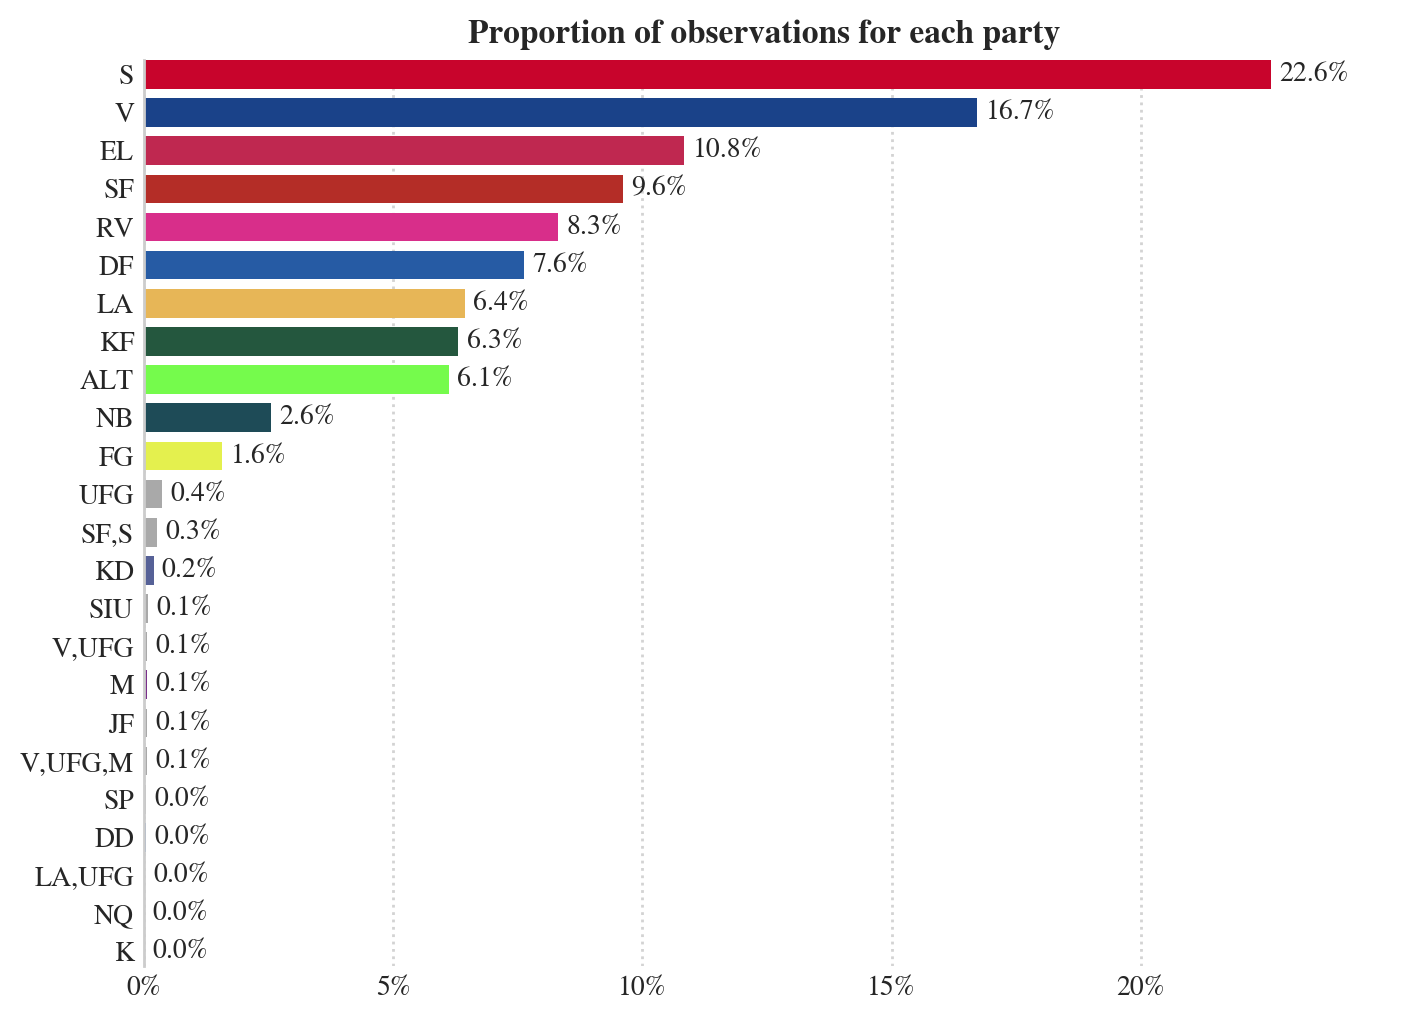

In [91]:
fig, ax = plt.subplots(figsize = (8,6))
bar_labs = party_counts['party'] * 100

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.barh(party_counts.index, width = party_counts['party'], height = 0.75, color = party_counts['color'])
ax.margins(0.1, 0)
ax.yaxis.grid(False)
ax.xaxis.grid(color='lightgrey', linestyle=':', linewidth=1) 
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.bar_label(ax.containers[0], labels=[f'{lab:,.1f}%' for lab in bar_labs.values], padding = 3)

plt.title('Proportion of observations for each party', weight = 'bold')
plt.show()

In [92]:
party_counts = pd.DataFrame(df.groupby('source')['party'].value_counts(normalize = True).sort_values(ascending = False)).rename(columns = {'party': 'prop'})
party_counts = party_counts.reset_index()
party_counts['color'] = party_counts['party'].map(colormap).fillna('darkgrey')

In [93]:
new_cmap = party_counts[['party', 'color']].drop_duplicates(subset = 'party').set_index('party').T.to_dict(orient = 'records')[0]

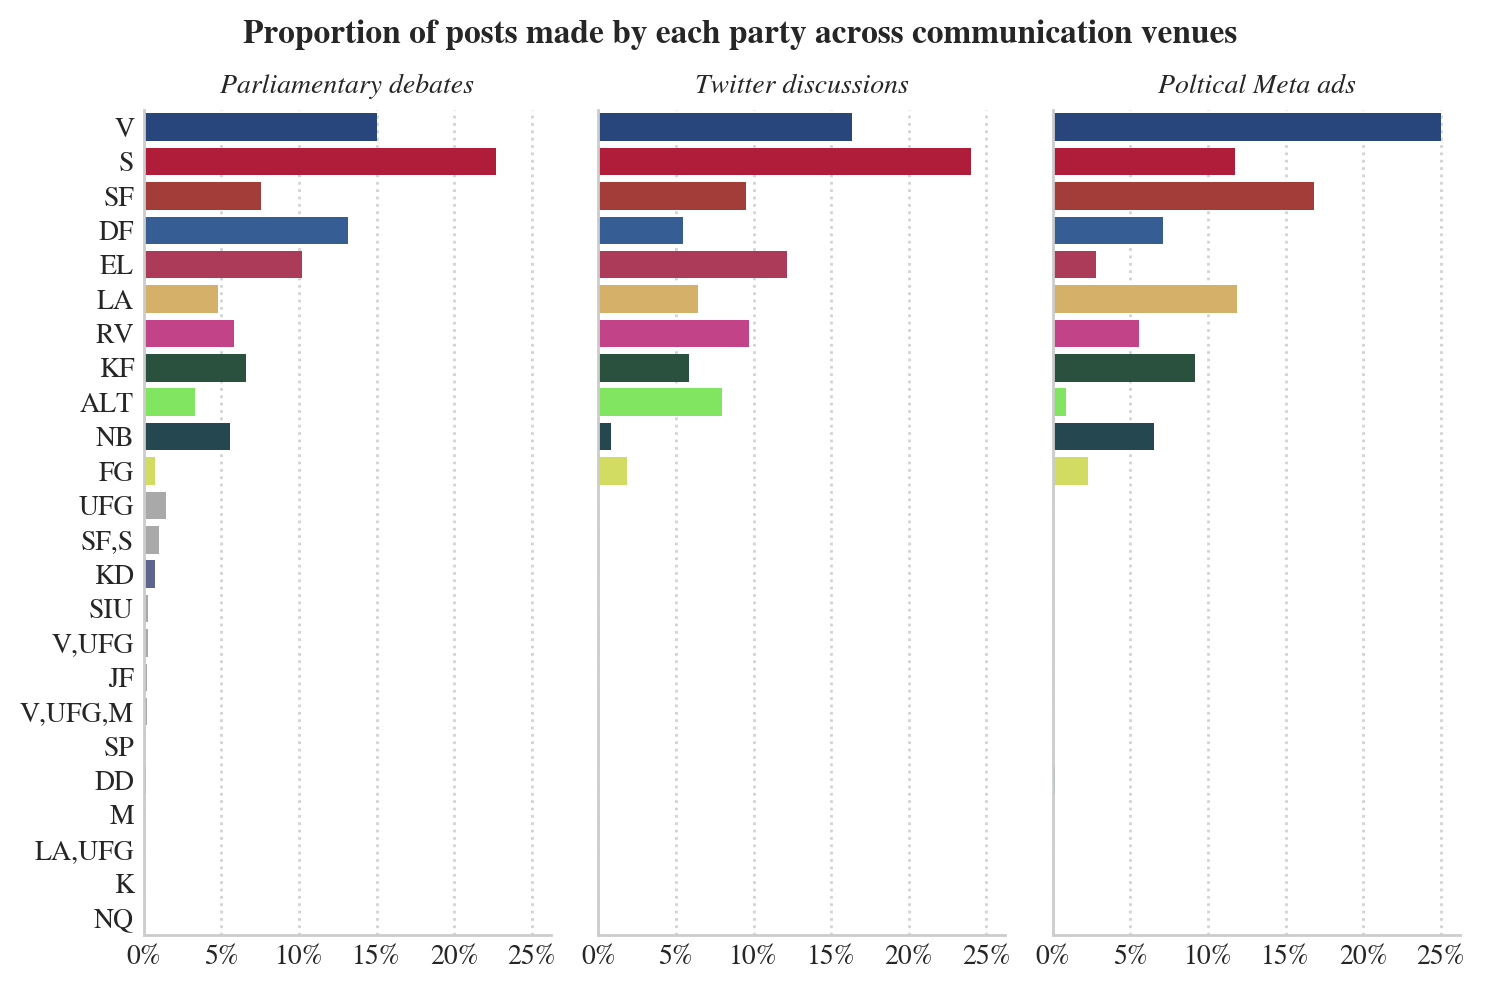

In [94]:
g = sns.catplot(
    data = party_counts,
    y = 'party',
    x = 'prop',
    palette = new_cmap,
    kind = 'bar',
    orient = 'h',
    col = 'source',
    height = 5, 
    aspect = 0.5,
    margin_titles = True,
    col_order = ['parliament', 'twitter', 'meta'],
    #saturation = 1
)

for ax in g.axes.flat:
    ax.xaxis.grid(color='lightgrey', linestyle=':', linewidth=1) 
    plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

col_labs = ['Parliamentary debates', 'Twitter discussions', 'Poltical Meta ads']

for i, lab in enumerate(col_labs):
    g.axes.flat[i].set_title(lab, style='italic', size = 10)
    #print(ax.containers[0])#ax.bar_label(ax.containers[0], labels=[f'{lab:,.1f}%' for lab in bar_labs.values], padding = 3)

g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Proportion of posts made by each party across communication venues', weight = 'bold')
plt.show()

In [64]:
list(df.columns)

['index', 'doc', 'source', 'start_time', 'full_name', 'level', 'party']

In [25]:
def calculate_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 *IQR) # TODO: Per group
    outliers = df.loc[filter]
    
    return outliers

In [105]:
def draw_volume_boxes(source = 'parliament', label_jitter = 1):

    politician_docs = (
        pd.DataFrame(
            df
            .loc[df['level'] == 'politician']
            .groupby(['full_name', 'party', 'source']).count()['doc'])
            .reset_index()
    )

    politician_docs = politician_docs.loc[politician_docs['source'] == source]

    politician_docs['color'] = politician_docs['party'].map(colormap).fillna('lightgrey')

    sort = politician_docs.groupby('party').median().sort_values(by = 'doc', ascending = False).index

    #politician_docs.plot(x = 'party', y = 'doc', kind='scatter', color = politician_docs['color']);
    PROPS = {
        'boxprops':{'alpha':.3},
        'medianprops':{'alpha':.3},
        'whiskerprops':{'alpha':.3},
        'capprops':{'alpha':.3}
    }

    sns.catplot(
        y = 'party',
        x = 'doc',
        data = politician_docs,
        color = None,
        palette = new_cmap,
        height = 6,
        aspect = 1.8,
        order = sort,
        kind = 'box',
        orient = 'horizontal',
        showcaps = False,
        flierprops = {
            'marker': 'x',
        }
        #boxprops={'alpha':.5},
        #**PROPS
    )

    #sns.stripplot(
    #    y = 'party',
    #    x = 'doc',
    #    data = politician_docs,
    #    palette = new_cmap,
    #    order = sort,
    #    orient = 'horizontal',
    #    alpha = 1
    #)
    parties = list(sort)
    outlier_list = []

    for party in parties:
        party_df = politician_docs.loc[politician_docs['party'] == party]
        outliers = calculate_outliers(party_df, 'doc')
        outlier_list.append(outliers)

    outliers_combined = pd.concat(outlier_list)
    
    for row in outliers_combined.itertuples():
        party_position = list(sort).index(row[2]) + random.uniform(-label_jitter, label_jitter)
        docs = row[4] + 10
        name = row[1]
        
        plt.text(
            docs,
            party_position,
            f'{name}',
            ha='left',
            va='center',
            path_effects=[pe.withStroke(linewidth=3, foreground='white')]
        )

    plt.title(
        f'Distribution of MP utterance volumes by party ({source.title()})\n',
        weight = 'bold',
        size = 16
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

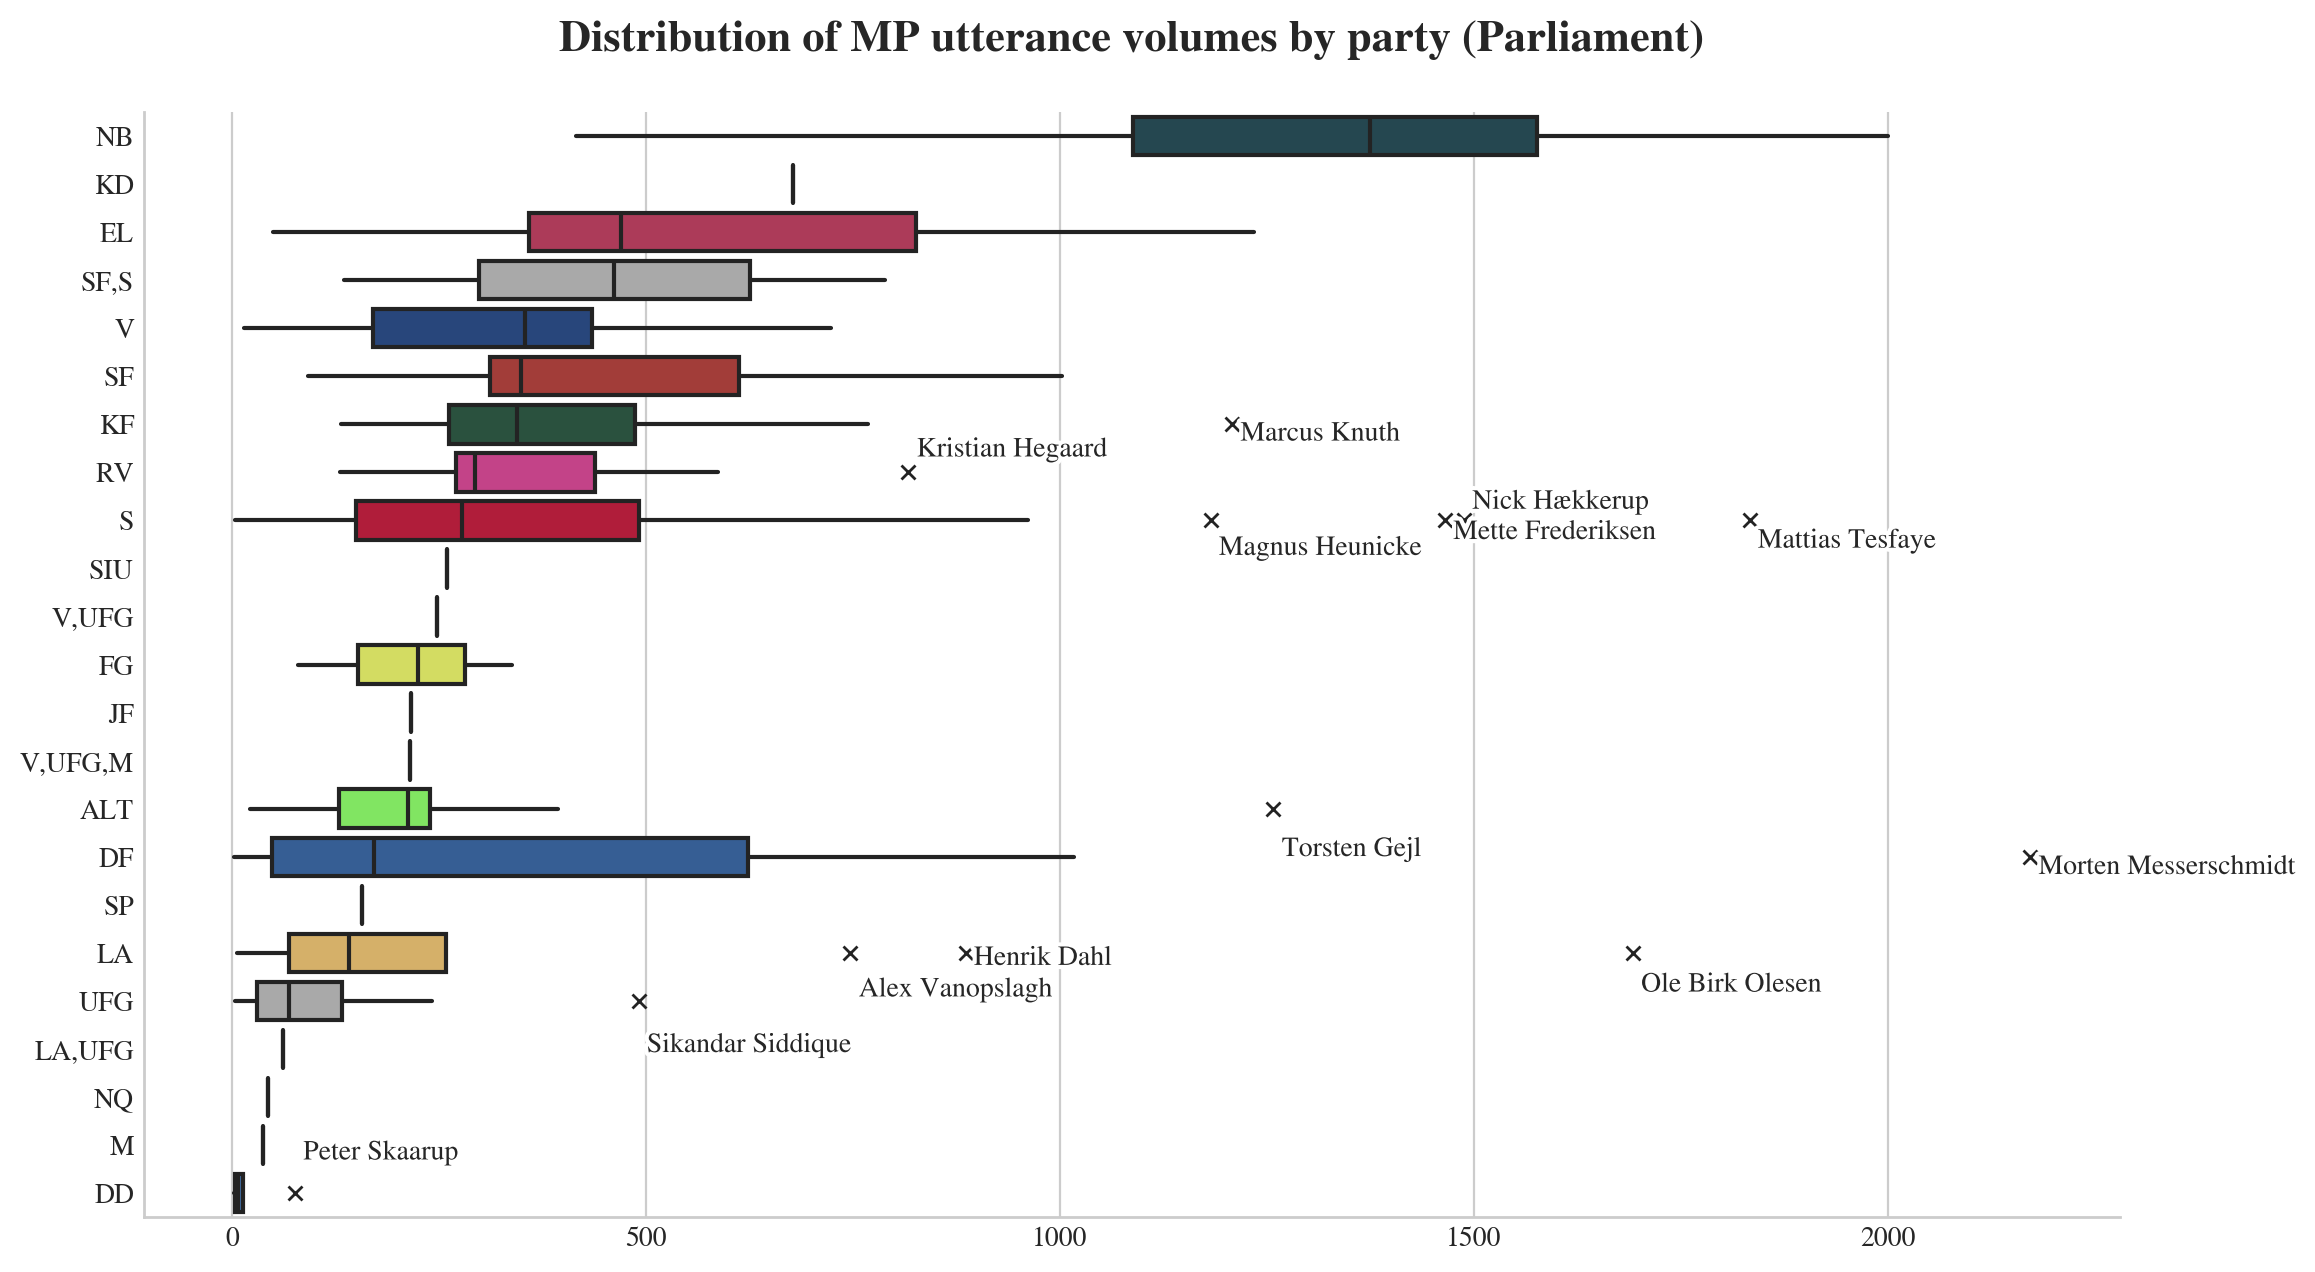

In [106]:
draw_volume_boxes(source = 'parliament', label_jitter = 1)

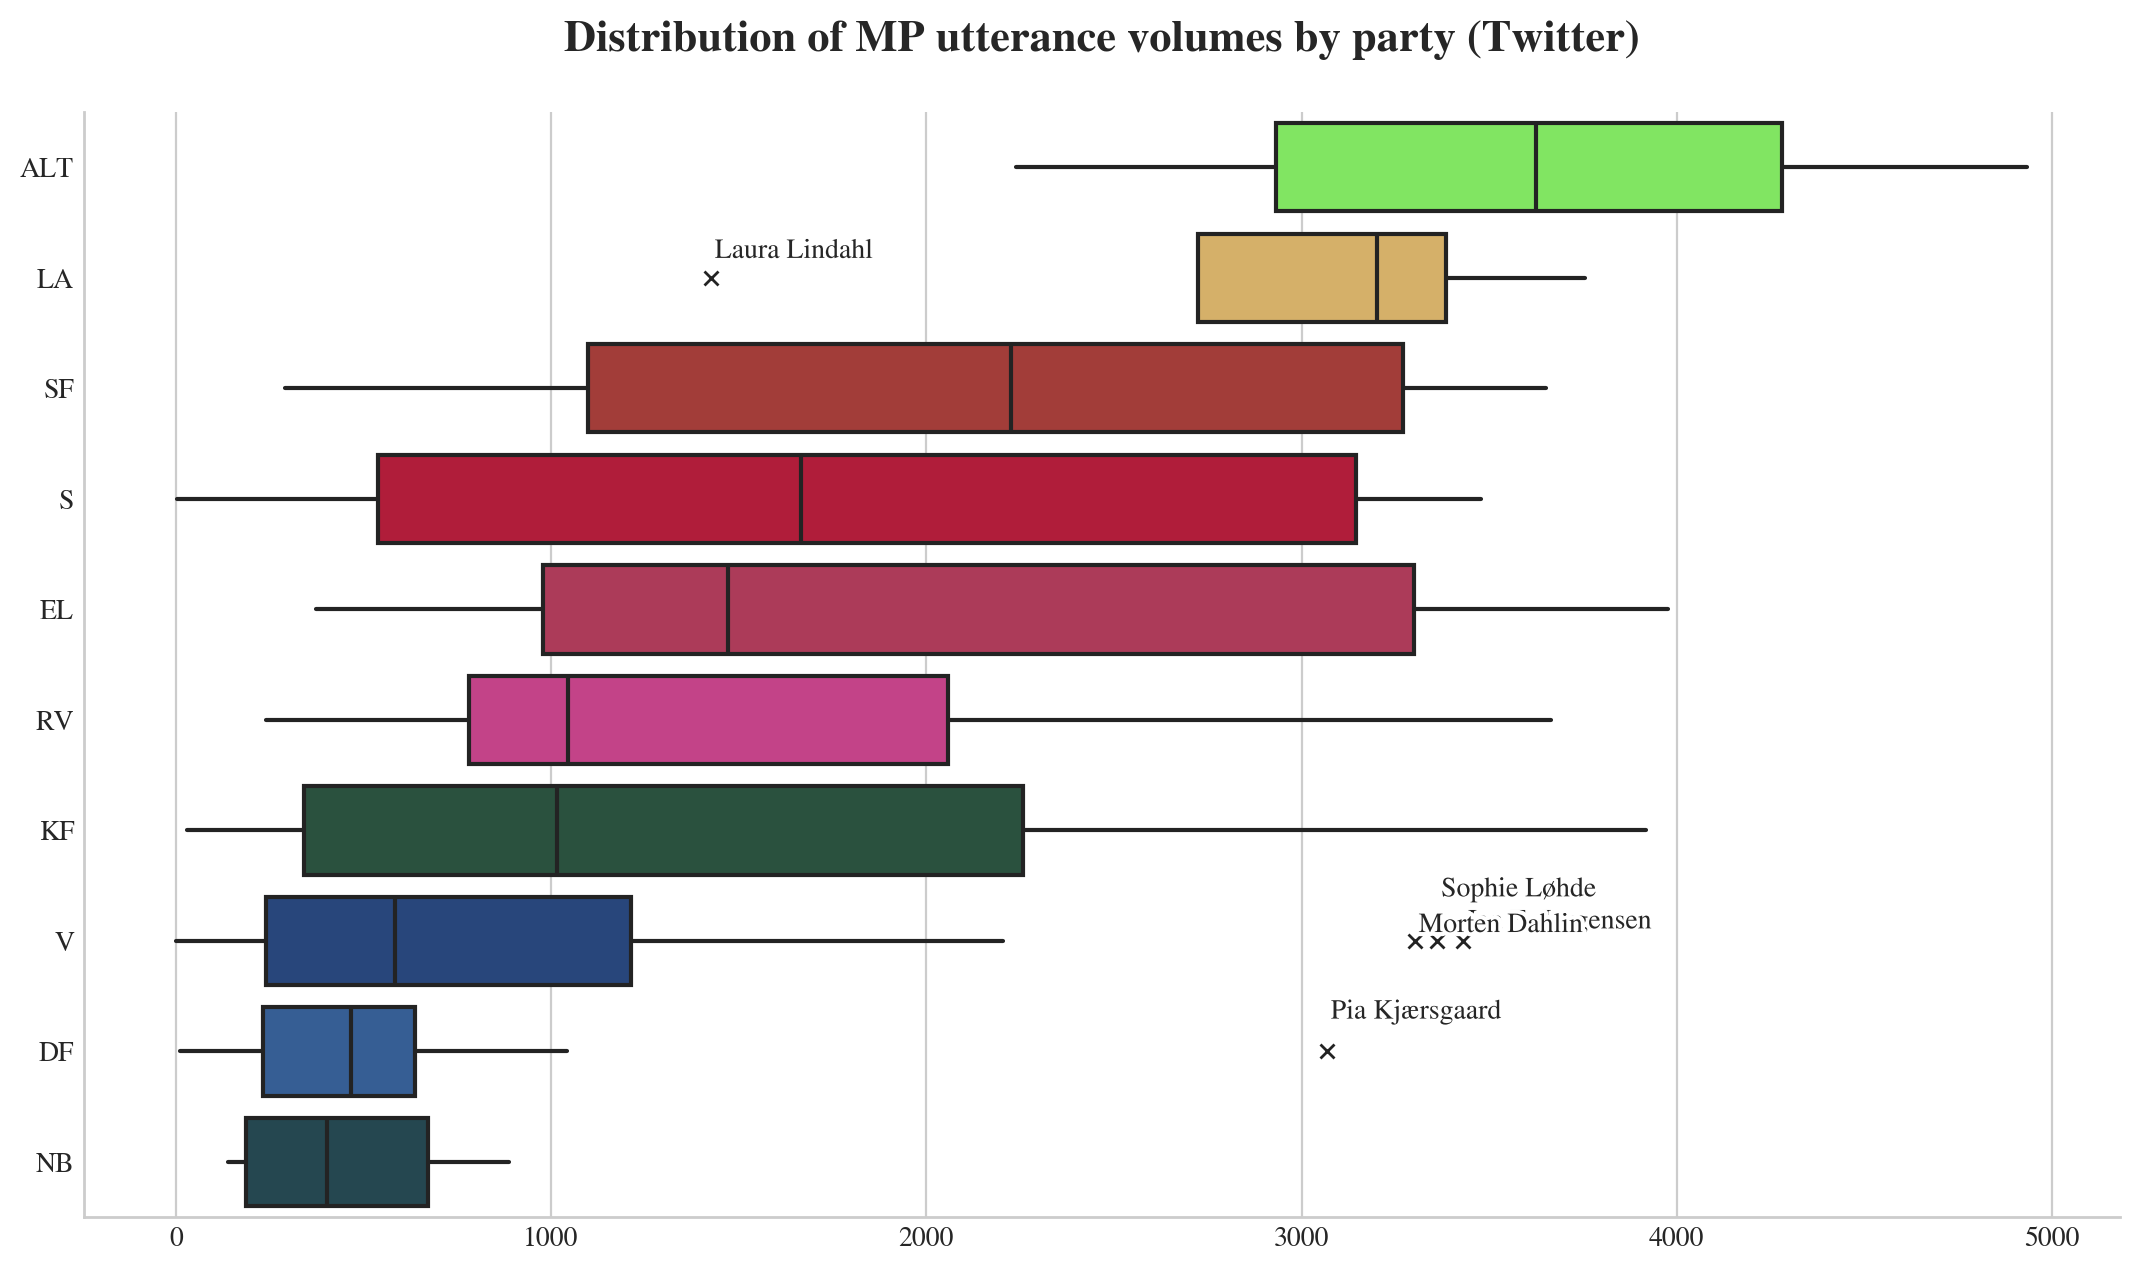

In [107]:
draw_volume_boxes(source = 'twitter', label_jitter = 0.5)

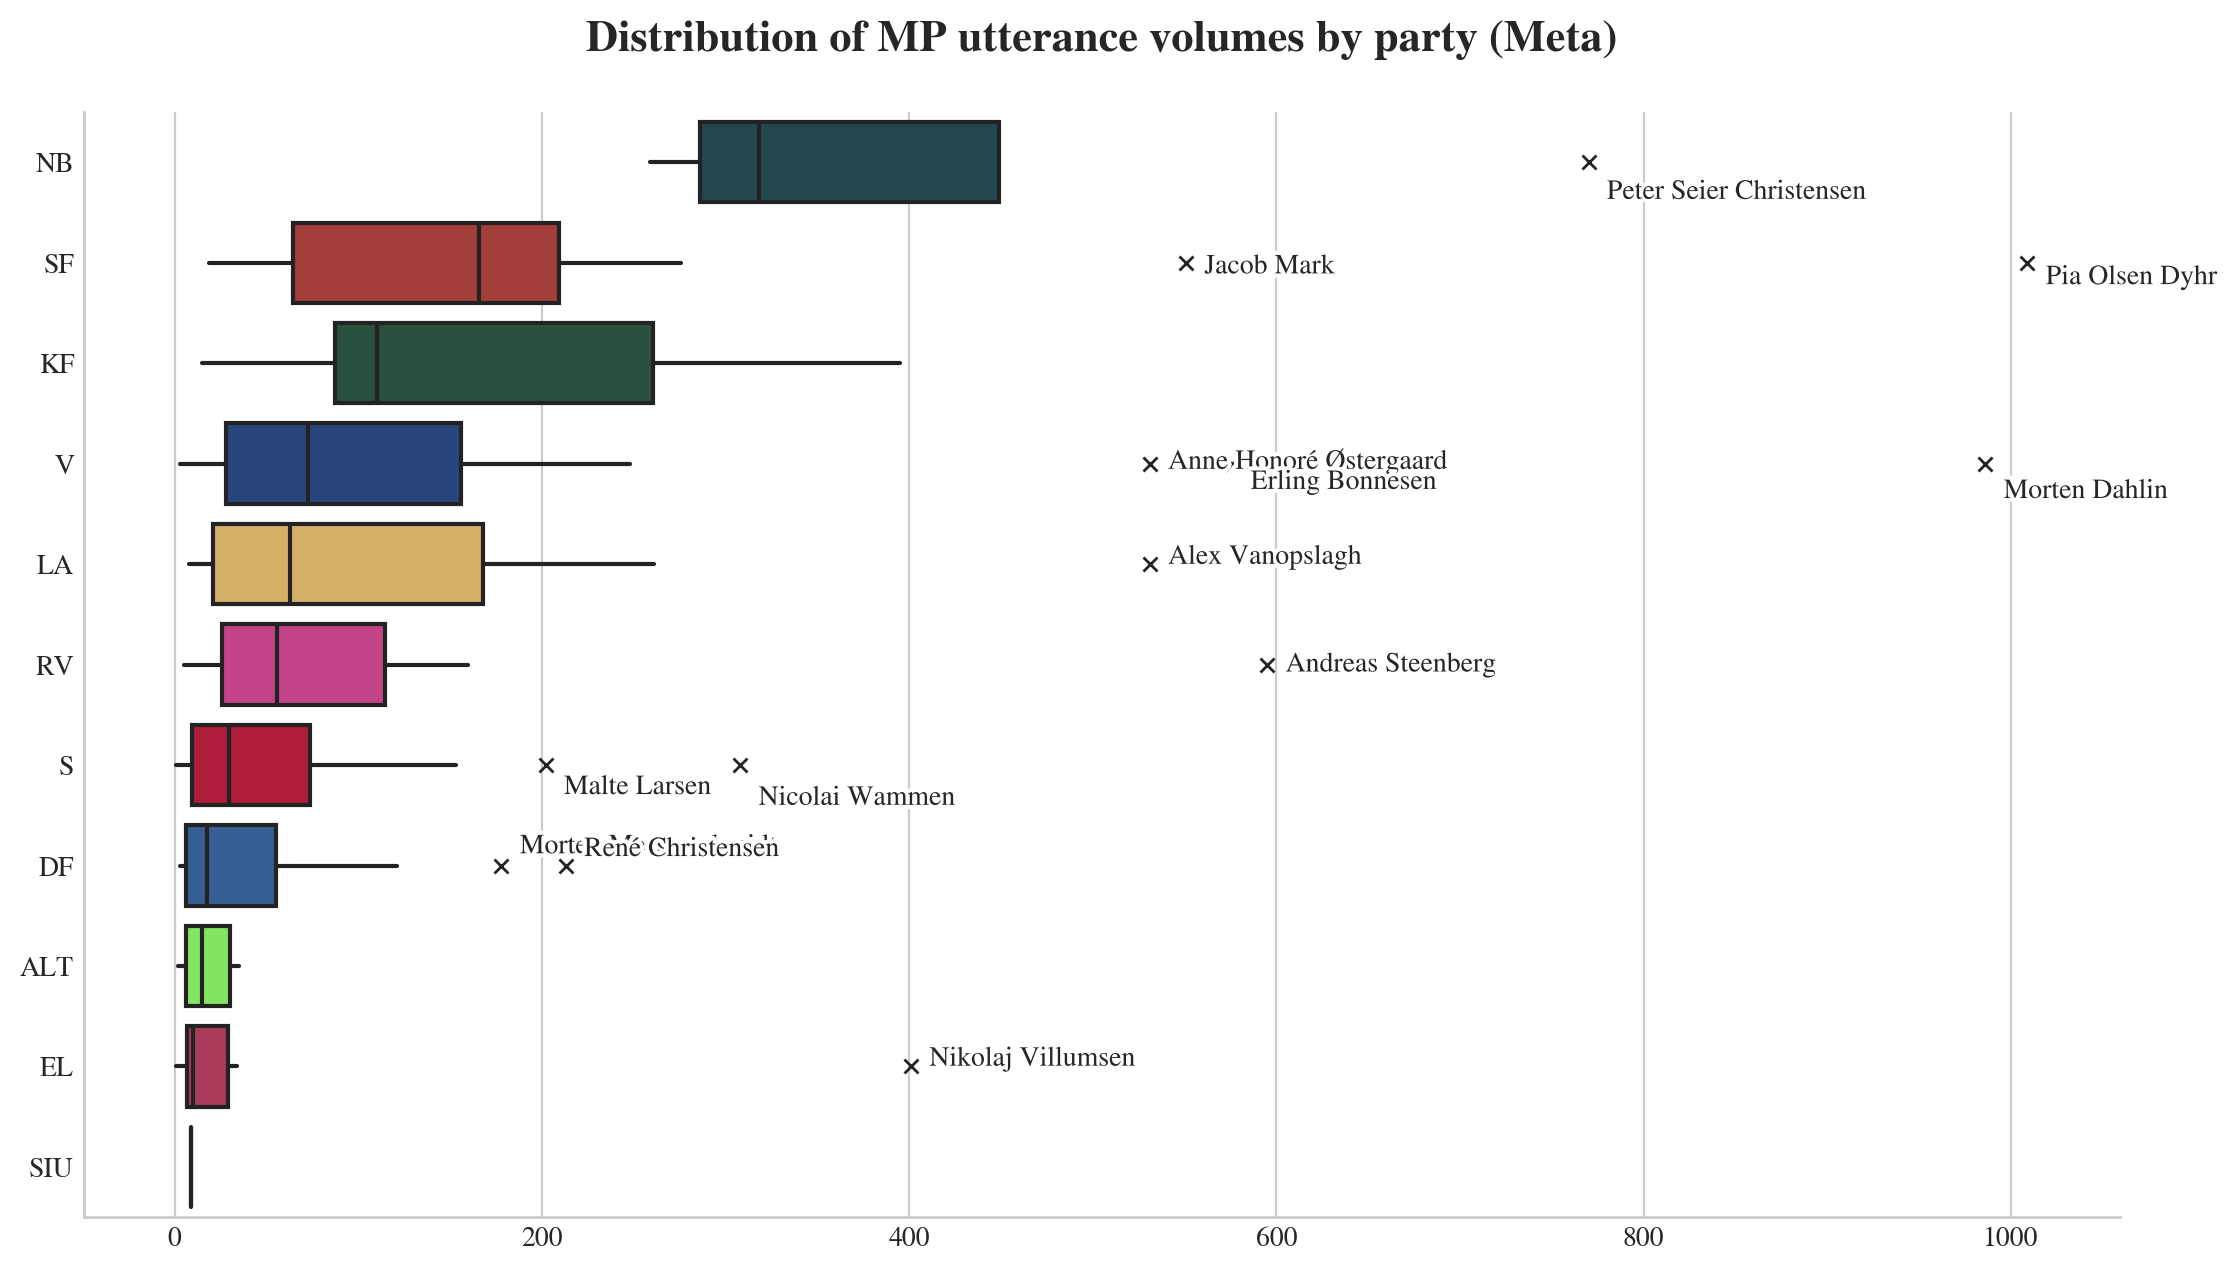

In [108]:
draw_volume_boxes(source = 'meta', label_jitter = 0.5)